In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.3          ✔ dplyr   1.0.1     
✔ tidyr   1.1.1          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "stockmarket"

In [2]:
library('igraph')

file_location = "../input/stockmarket/finance_data/Name_sector.csv"
data_directory = "../input/stockmarket/finance_data/data"
data_dir_slash = "../input/stockmarket/finance_data/data/"


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [3]:
company_tickers = read.csv(file_location,header=TRUE,stringsAsFactors=FALSE)
head(company_tickers,n = 15L)

cat(paste('Number of companies in ticker list: ',nrow(company_tickers), sep=''))

,Symbol,Sector
,<chr>,<chr>
1,A,Health Care
2,AAL,Industrials
3,AAP,Consumer Discretionary
4,AAPL,Information Technology
5,ABBV,Health Care
6,ABC,Health Care
7,ABT,Health Care
8,ACN,Information Technology
9,ADBE,Information Technology


Number of companies in ticker list: 505

In [4]:
filenames <- list.files(data_dir_slash, pattern="*.csv")
filenames = paste(data_directory, filenames, sep="/")
cat(paste('Number of companies in ticker list: '),length(filenames), sep='' )
comp_del=0
for(j in c(1:length(filenames))){
    comp_data = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    if(dim(comp_data)[1]!=765){
        comp_del=comp_del+1
    }
}
print(sprintf("Number of companies in the ticker list with missing data: %s",comp_del))

Number of companies in ticker list: 505[1] "Number of companies in the ticker list with missing data: 11"


In [5]:
 
i=1
#ith stock
log_norm_return = matrix(0,length(filenames)-comp_del,764)
num_data_points=c()
for(j in c(1:length(filenames))){
    comp_data = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    num_data_points[j] = dim(comp_data)[1]
    if(num_data_points[j]==765){
        p = comp_data[,5] # closing prices
        q = c() # list of return of stock over a period of [t − 1, t]q[1] = p[1] 
        r = c()
        for(t in c(2:length(p))){
            q[t-1] = (p[t]-p[t-1])/p[t-1]
        }
        r = log(1+q)
        log_norm_return[i,] = r
        i = i+1
    }
}

In [6]:
generate_correlation_weights= function(wt_file, log_norm_return,company_tickers)
{
    cat("from_node","\t","to_node","\t","edge_wt",file=wt_file)
    num_companies = dim(log_norm_return)[1]
    for(i in c(1:(num_companies-1))){
        for(j in c((i+1):num_companies)){
            r_i = mean(log_norm_return[i,])
            r_j = mean(log_norm_return[j,])
            r_ij = mean(log_norm_return[i,]*log_norm_return[j,])
            r_i_squared = log_norm_return[i,]^2
            r_j_squared = log_norm_return[j,]^2
            p_ij = (r_ij-(r_i*r_j))/(sqrt((mean(r_i_squared)-(r_i^2))*(mean(r_j_squared)-(r_j^2))))
            w_ij = sqrt(2*(1-p_ij))
            cat('\n',company_tickers[i,1],'\t',company_tickers[j,1],'\t',w_ij,file=wt_file)
        }
    }
}



#remove companies w/incomplete data
comp_ignore=which(num_data_points!=765)
company_tickers=company_tickers[-comp_ignore,]


wt_file <- file("./edge_weights.txt", "w")
generate_correlation_weights(wt_file,log_norm_return,company_tickers)
close(wt_file)

,from_node,to_node,edge_wt
,<fct>,<fct>,<dbl>
1,A,AAL,1.189554
2,A,AAP,1.269710
3,A,AAPL,1.373192
4,A,ABBV,1.129386
5,A,ABC,1.248807
6,A,ABT,1.021796
7,A,ACN,1.055284
8,A,ADBE,1.098334
9,A,ADI,1.107646


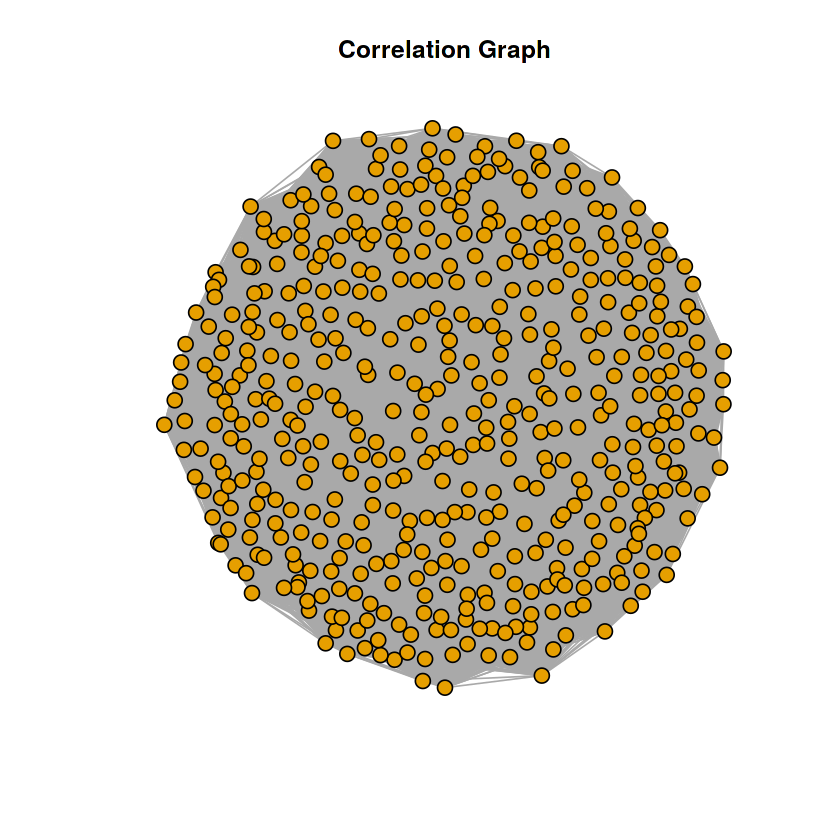

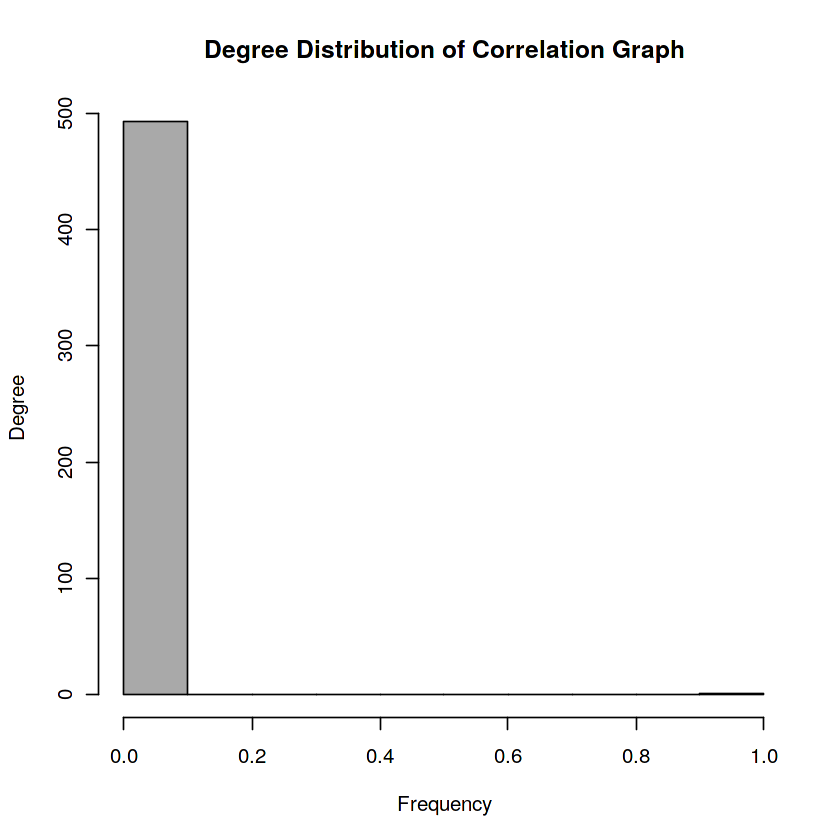

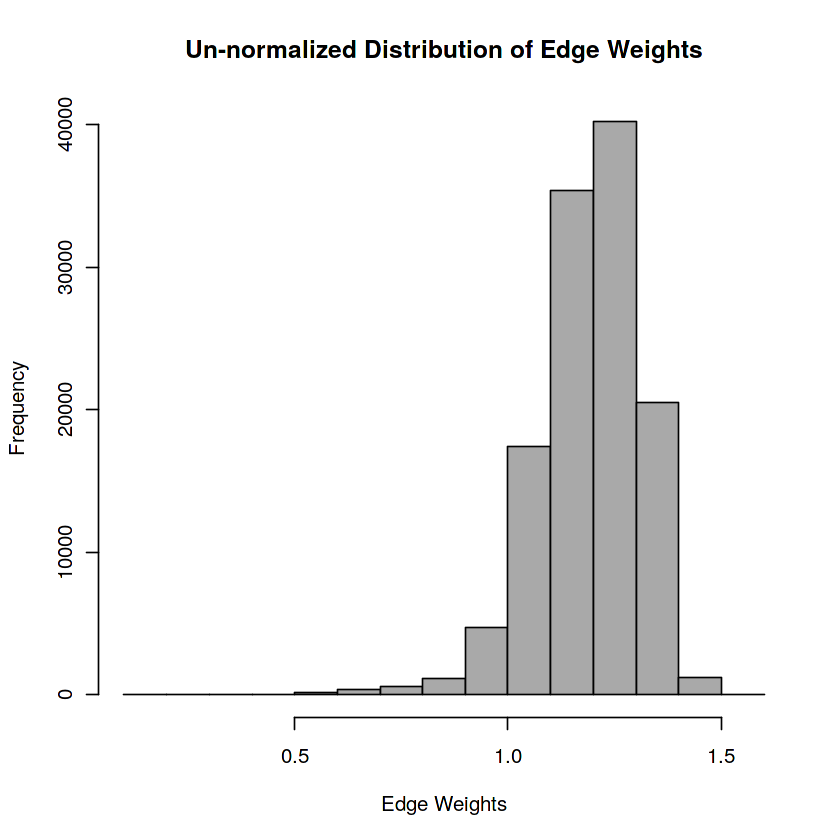

In [7]:
edge_list= read.delim("./edge_weights.txt",header=TRUE)
corr_graph = graph.data.frame(edge_list, directed = FALSE)
E(corr_graph)$weight = edge_list[,"edge_wt"]


head(edge_list,n = 15L)
plot(corr_graph, vertex.label="", vertex.size=5,main="Correlation Graph")
hist(degree.distribution(corr_graph),col="darkgrey",main="Degree Distribution of Correlation Graph", ylab="Degree",xlab="Frequency")
hist(edge_list[,"edge_wt"],col="darkgrey",main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")

In [8]:
comp_sectors = unique(company_tickers[,2])
cat(paste('Number of unique sectors: '), length(comp_sectors), '\n', sep='')
cat(comp_sectors)

Number of unique sectors: 11
Health Care Industrials Consumer Discretionary Information Technology Consumer Staples Utilities Financials Real Estate Materials Energy Telecommunication Services

In [9]:
min_span_tree = mst(corr_graph,algorithm="prim")
min_span_tree
cat(paste('Number of edges in the MST: '), ecount(min_span_tree), '\n', sep='')
cat(paste('Number of vertices in the MST: '), vcount(min_span_tree), '\n', sep='')


IGRAPH 00a2605 UNW- 494 493 -- 
+ attr: name (v/c), edge_wt (e/n), weight (e/n)
+ edges from 00a2605 (vertex names):
 [1]  A    -- TMO    AAL  -- DAL    AAP  -- ORLY   AAPL -- UNP    ABBV -- AMGN 
 [6]  ABC  -- CAH    ABT  -- HOLX   ABT  -- MDT    ABT  -- TMO    ABT  -- VAR  
[11]  ACN  -- CTSH   ACN  -- FISV   ACN  -- ORCL   ACN  -- RHT    ADBE -- CRM  
[16]  ADBE -- INTU   ADI  -- TXN    ADI  -- XLNX   ADM  -- PFG    ADP  -- PAYX 
[21]  ADS  -- DFS    ADSK -- MCO    AEE  -- XEL    AEP  -- DUK    AEP  -- ETR  
[26]  AEP  -- FE     AEP  -- PPL    AEP  -- XEL    AES  -- CNP    AES  -- NRG  
[31]  AET  -- ANTM   AET  -- CNC    AET  -- HUM    AET  -- UNH    AFL  -- PRU  
[36]  AGN  -- AMGN   AGN  -- MYL    AIG  -- JPM    AIV  -- REG    AIV  -- UDR  
+ ... omitted several edges

Number of edges in the MST: 493
Number of vertices in the MST: 494


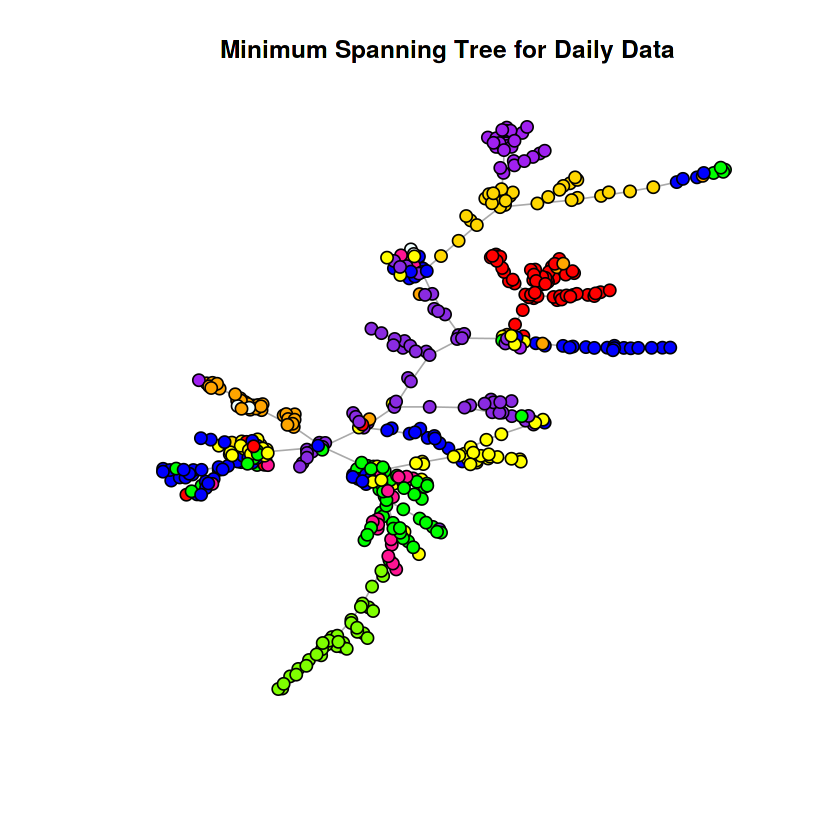

In [10]:
sector_colors = list("Health Care"="red","Industrials"="green","Consumer Discretionary"="blue",
              "Information Technology"="yellow","Consumer Staples"="orange","Utilities"="purple","Financials"="blueviolet",
              "Real Estate"="gold","Materials"="deeppink","Energy"="chartreuse","Telecommunication Services"="azure")

sector_color_mapping = function(corr_graph,company_tickers, sector_colors)
{
    color_map = c()
    for(v in c(1:vcount(corr_graph))){
        sector = company_tickers[v,2]
        color_map[v] = sector_colors[[sector]]
    }
    return(color_map)
}

color_map = sector_color_mapping(corr_graph,company_tickers,sector_colors)
plot(min_span_tree,vertex.size=4, vertex.label=NA, vertex.color=color_map, main=" Minimum Spanning Tree for Daily Data")

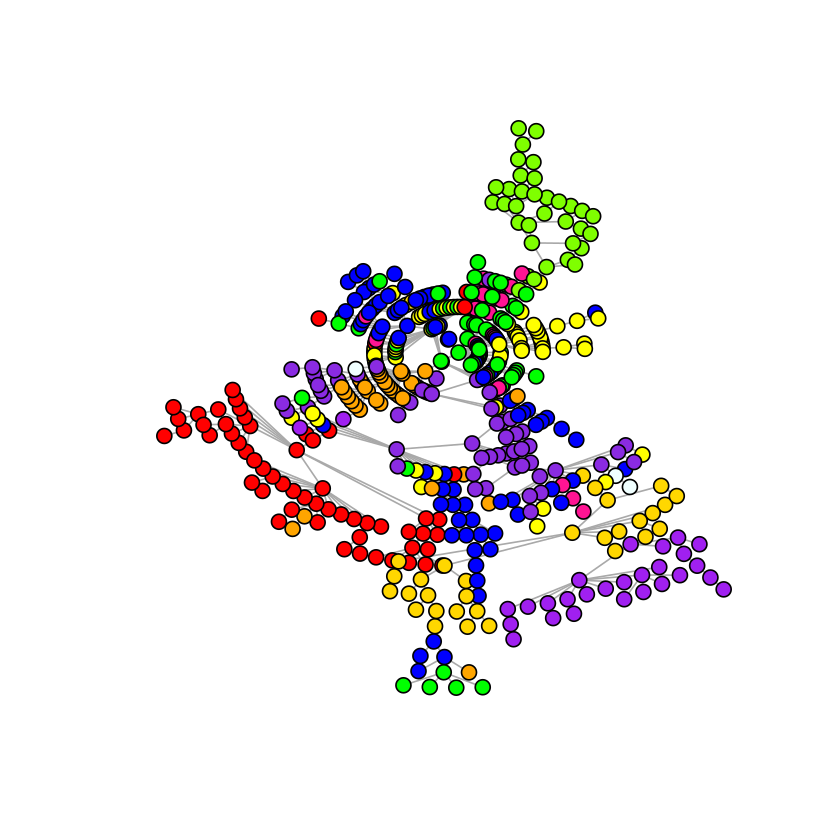

In [11]:
plot(min_span_tree,vertex.size=5, vertex.label=NA, vertex.color=color_map, layout=layout.reingold.tilford(min_span_tree,circular=T))


In [12]:
# Find the value of S_i for all i: The number of members in each community. 
S_i = c()
cat('Number of nodes belonging each Sector')
for(i in c(1:length(comp_sectors))){
    S_i[i] = length(which(company_tickers[,2]==comp_sectors[i]))
    print(sprintf("%s: %s", comp_sectors[i], S_i[i]))
}

# find alpha for 
p_method_1 = c()
p_method_2 = c()
for(v in c(1:vcount(min_span_tree)))
{
    neighbors_v = neighbors(min_span_tree,v)
    N_i = length(neighbors_v)
    Q_i=0
    for(i in neighbors_v){
        if(company_tickers[i,2]==company_tickers[v,2])
            Q_i=Q_i+1
    }
    p_method_1[v] = Q_i/N_i
    p_method_2[v] = S_i[which(comp_sectors==company_tickers[v,2])]/vcount(min_span_tree)
}
alpha_1 = sum(p_method_1)/vcount(min_span_tree)
cat(paste('Alpha value for method 1: '), alpha_1, '\n', sep='')

alpha_2 = sum(p_method_2)/vcount(min_span_tree)
cat(paste('Alpha value for method 2: '), alpha_2, '\n', sep='')



Number of nodes belonging each Sector[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 36"
[1] "Utilities: 28"
[1] "Financials: 63"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"
Alpha value for method 1: 0.8289301
Alpha value for method 2: 0.1141881
